In [55]:
import numpy as np
import matplotlib.pyplot as plt

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input


In [56]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [78]:
import itertools
import math

def divisive_shap_approx(X, y, model, beta, gamma_n, gamma_d):
    if X.shape[1] > np.emath.logn(beta, n):
        split_S = partition(X,y,model)
        gamma_n = gamma_n*value(X, y, model)
        gamma_d = gamma_d*sum([value(Xi, yi, model) for Xi, yi in split_S])
        return union([divisive_shap_approx(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)
        

def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(X, y, model):
    """Returns list of tuples: [(X1, Y1), (X2, Y2), ...]"""
    N = X.shape[1]
    return [(X[:,:N//2], y), (X[:,N//2:], y)]

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)


In [80]:
def main(X, y, model, beta):
    X2, y2, shap = divisive_shap_approx(X, y, model, beta, 1, 1)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

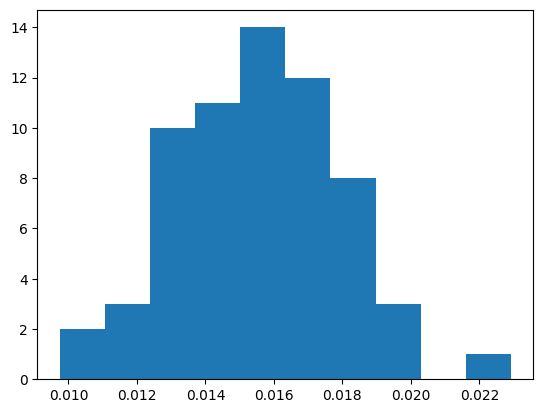

In [88]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()


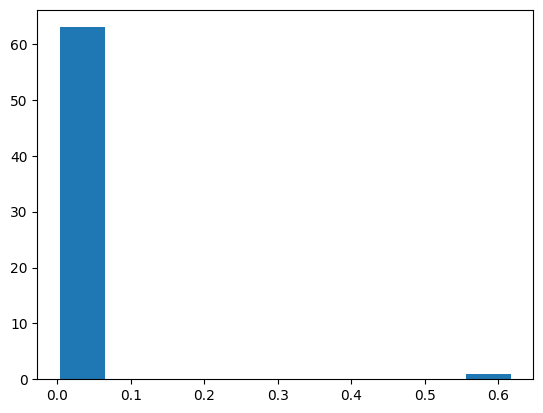

In [89]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
X[:,0] = X[:,0]*10
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()